# Bakersfield PM2.5 Prediction
 This notebook focuses on obtaining the best subset of the database for Bakersfield city in California to train a model for predicting PM2.5 concentration in the air.<br>
 
<img src="images/reference.png" alt="" style="width:450px;"> 
<img src="images/city.png" alt="" style="width:450px;">

# Merge the Data

In [ ]:
import pandas as pd

dfs = {}

for i in range(1999, 2025):
    dfs[f"df{i-1998}"] = pd.read_csv(f"data_raw/pm25_{i}.csv")

data = pd.concat(dfs.values(), ignore_index=True, verify_integrity=True)

data.to_csv('data_mod/data_merge.csv', index=False) 



## Check the Data

All the data in Bakersfield

In [ ]:
all((data['CBSA_NAME'].unique())=='Bakersfield, CA')

Split Bakersfield sites

In [ ]:
equal = data['Site Name'].nunique() == data['Site ID'].nunique()

if equal:
    print("IDs=Sites Names.")
else:
    print("IDs!=Sites Names.")


for i, (site_id, group) in enumerate(data.groupby('Site ID'), start=1):
    filename = f"data_mod/id_{i}.csv"
    group.to_csv(filename, index=False)


The site with the most data on Bakersfield

In [ ]:
num_rows_per_id = []

for site_id in range(1, 13):
    filename = f"data_mod/id_{site_id}.csv"
    df = pd.read_csv(filename)
    
    num_rows = len(df)
    num_rows_per_id.append(num_rows)

    print(f"The DataFrame for 'Site ID' {site_id} has {num_rows} rows.")


Check duplitcates

In [ ]:
import pandas as pd

# Load the DataFrame from the CSV file
data = pd.read_csv("data_mod/id_3.csv")

data_original = data.copy()

data_unique = data.drop_duplicates()

print(f'DataFrame original shape: {data_original.shape}')
print(f'data unique shape: {data_unique.shape}')

# Select  data (and Start modules)

##### Select Data (Start modules)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data = pd.read_csv("data_mod/id_3.csv")
data.rename(columns={'Daily Mean PM2.5 Concentration': 'pm25', 'Date': 'day'}, inplace=True)

def reset_data_mod(): 
    global data_mod
    data_mod = data[ ['day', 'pm25']].copy()
    data_mod['day'] = pd.to_datetime(data_mod['day'], format='%m/%d/%Y', errors='coerce')
    data_mod.sort_values(by='day', inplace=True)
    data_mod.set_index(['day'], inplace=True, drop=True)
reset_data_mod()  



##### Data Plot

Text(0, 0.5, 'pm25')

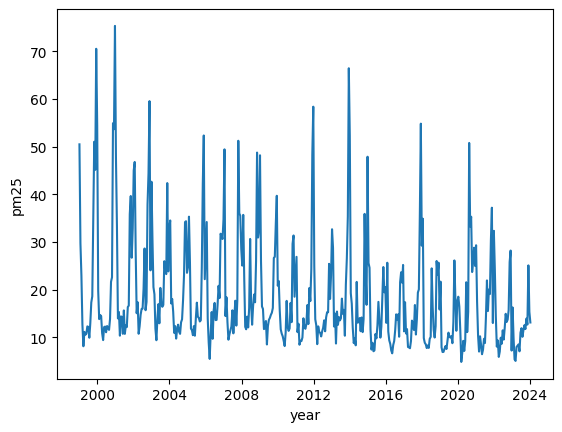

In [5]:
plt.plot(data_mod.index, data_mod['pm25'])
plt.xlabel('year')
plt.ylabel('pm25')

##### Data Temporal Resizing and fill NaN

In [13]:
tem_nan = data_mod['pm25'].isna().any()

if tem_nan:
    print("A coluna 'pm25' contém valores NaN.")
else:
    print("A coluna 'pm25' não contém valores NaN.")

A coluna 'pm25' não contém valores NaN.


In [14]:
def resize_data_mod(time_freq):
    global data_mod
    
    reset_data_mod()
    
    data_mod=data_mod.resample(time_freq).mean()
    data_mod = data_mod.fillna(data_mod.mean())
resize_data_mod("30D")
data_mod.head(50)

,pm25
day,
1999-01-03,41.687500
1999-02-02,26.277778
1999-03-04,11.146429
1999-04-03,9.964000
1999-05-03,10.995745
1999-06-02,11.214286
1999-07-02,11.813158
1999-08-01,11.429787
1999-08-31,17.662500


##### Data split (train, val,test)

# Analisys

## Convert the date to Unix timestamps ( create new colunnm numerical_date)

In [15]:
def convert_to_numerical_date():
    global data_mod
    data_mod['numerical_date'] = (data_mod.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    
convert_to_numerical_date()
data_mod.head(1)


,pm25,numerical_date
day,,
1999-01-03,41.6875,915321600


## Normalize Data

In [16]:
def normalize_data():
    global data_mod_normalized
    convert_to_numerical_date()
    numeric_columns = ['numerical_date', 'pm25']
    data_mod_numeric = data_mod[numeric_columns]
    data_mod_normalized = (data_mod_numeric - data_mod_numeric.mean()) / data_mod_numeric.std()
    
normalize_data()
data_mod_normalized.head()


,numerical_date,pm25
day,,
1999-01-03,-1.723577,2.166523
1999-02-02,-1.712274,0.729019
1999-03-04,-1.700972,-0.682517
1999-04-03,-1.689670,-0.792821
1999-05-03,-1.678368,-0.696574


## PCA

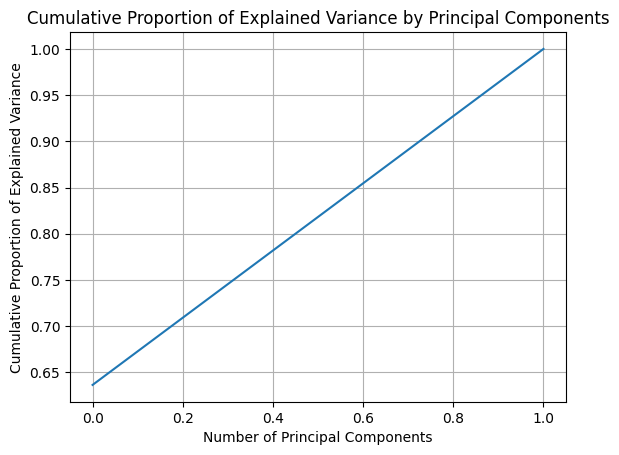

[0.63638223 0.36361777]
Temporal cutoff interval: 0.9999999999999991


In [17]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(data_mod_normalized)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Proportion of Explained Variance')
plt.title('Cumulative Proportion of Explained Variance by Principal Components')
plt.grid(True)
plt.show()
# Apply PCA
pca = PCA(n_components=2) 

principal_components = pca.fit_transform(data_mod_normalized)

print(pca.explained_variance_ratio_)  # Variance explained by each principal component

component_weights = pca.components_[1]  
temporal_cutoff = component_weights[1] / component_weights[0]  

print("Temporal cutoff interval:", temporal_cutoff)

## MPCA

In [19]:
import tensorly as tl
from tensorly.decomposition import parafac
import numpy as np

numeric_columns = ['numerical_date', 'pm25']
data_mod_numeric = data_mod[numeric_columns]
data_mod_normalized = (data_mod_numeric - data_mod_numeric.mean()) / data_mod_numeric.std()
data_numerical_date = data_mod_normalized['numerical_date'].values.reshape(-1, 1, 1)
data_pm25 = data_mod_normalized['pm25'].values.reshape(-1, 1, 1)



tensor_data = tl.tensor(np.concatenate([data_numerical_date, data_pm25], axis=1))

print("Tensor_data Shape:", tensor_data.shape)

print("Type of tensor_data:", tensor_data.dtype)

# MPCA
components = parafac(tensor_data, rank=2)

# Extract components
component_1 = components.factors[0]  # Componente 1
component_2 = components.factors[1]  # Componente 2


Tensor_data Shape: (306, 2, 1)
Type of tensor_data: float64


In [20]:
print("explained_variance_ratio_ 1:", pca.explained_variance_ratio_[0])
print("explained_variance_ratio_ 2:", pca.explained_variance_ratio_[1])


explained_variance_ratio_ 1: 0.6363822267511748
explained_variance_ratio_ 2: 0.36361777324882527


In [21]:
component_1_weights = component_1[:, 0] 
temporal_cutoff = component_1_weights[0] / component_1_weights[1]
print("temporal cut:", temporal_cutoff)

temporal cut: 1.5934585541260453


## MMI (Multivariate Mutual Information)

In [22]:
from sklearn.feature_selection import mutual_info_regression

x = data_mod_normalized[["numerical_date"]]  
y = data_mod_normalized["pm25"]  

mi_score = mutual_info_regression(x, y)[0]

print("Mutual Information between 'numerical_date' and 'pm25':", mi_score)

Mutual Information between 'numerical_date' and 'pm25': 0.09336779225382319


In [29]:
import numpy as np
from sklearn.feature_selection import mutual_info_regression

time = data_mod_normalized["numerical_date"].values.reshape(-1, 1)
pm25 = data_mod_normalized["pm25"].values

mutual_info = mutual_info_regression(time, pm25)


melhor_corte_temporal = time[np.argmax(mutual_info)]
print(melhor_corte_temporal)
print(mutual_info )


[-1.72357651]
[0.09082437]


## (HE) Holt-Winters Exponential Smoothing

In [81]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

data_he = data_mod[['pm25']].copy()

model = ExponentialSmoothing(data_he['pm25'], seasonal_periods=12, trend=None, seasonal='add')

model_fit = model.fit()

n = 100  
forecast =  model_fit.forecast(steps=n)
data_prev= pd.DataFrame(forecast)
data_prev.columns = ['pm25']
data_prev.index.name= 'day' 
data_prev.head()

,pm25
day,
2024-02-21,4.604319
2024-03-22,5.618348
2024-04-21,6.055608
2024-05-21,7.459403
2024-06-20,9.460981


In [50]:
forecast.to_csv('data_mod/forecast.csv', index=False)

In [61]:
forecast.head(5)

2024-02-21    4.604319
2024-03-22    5.618348
2024-04-21    6.055608
2024-05-21    7.459403
2024-06-20    9.460981
Freq: 30D, dtype: float64

In [57]:
reset_data_mod()
resize_data_mod("30D")
data_mod.tail()

,pm25
day,
2023-09-24,11.175806
2023-10-24,12.864103
2023-11-23,21.873333
2023-12-23,15.217241
2024-01-22,10.966667
